# 01_임베딩 3D 시각화

# 0. 기본 Library

In [36]:
import pandas as pd
import numpy as np

## 1. OpenAI 라이브러리 설치 확인

In [37]:
# !pip install openai python-dotenv ipympl

## 2. OpenAI 정보 읽기

In [38]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv(filename='./.env')
load_dotenv(dotenv_path=dotenv_path, override=True)
# override=True : .env 파일 변경시 refresh 없이 override 되도록 설정

openai.api_type = "azure"
openai.api_version = os.getenv("OPENAI_API_VERSION","").strip()

API_KEY = os.getenv("OPENAI_API_KEY","").strip()
assert API_KEY, "ERROR: Azure OpenAI Key is missing"
openai.api_key = API_KEY

RESOURCE_ENDPOINT = os.getenv("OPENAI_API_BASE","").strip()
assert RESOURCE_ENDPOINT, "ERROR: Azure OpenAI Endpoint is missing"
assert "openai.azure.com" in RESOURCE_ENDPOINT.lower(), "ERROR: Azure OpenAI Endpoint should be in the form: \n\n\t<your unique endpoint identifier>.openai.azure.com"
openai.api_base = RESOURCE_ENDPOINT

deployment_id ='text-embedding-ada-002'

## 3. 함수 정의

In [39]:
def get_embedding(text, deployment_id=deployment_id):
    """ 
    Get embeddings for an input text from the dataframe. 
    """
    result = openai.Embedding.create(
      deployment_id=deployment_id,
      input=text
    )
    result = np.array(result["data"][0]["embedding"])
    return result

def vector_similarity(x, y):
    """
    Returns the similarity between two vectors.    
    Because OpenAI Embeddings are normalized to length 1, the cosine similarity is the same as the dot product.
    """
    similarity = np.dot(x, y)
    return similarity 

def order_document_sections_by_query_similarity(query, contexts):
    """
    Find the query embedding for the supplied query, and compare it against all of the pre-calculated articles embeddings
    to find the most relevant articles. 
    Return the list of articles, sorted by relevance in descending order.
    """
    query_embedding = get_embedding(query)

    document_similarities = sorted(
        [(vector_similarity(query_embedding, doc_embedding), doc_index) for doc_index, doc_embedding in contexts.items()], 
        reverse=True)
    
    return document_similarities

## 4. 데이터 소스 Embedding

In [40]:
df_orig = pd.read_csv("../data/bbc-news-data.csv", delimiter='\t')
df = df_orig.copy()
df.head(5)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [41]:
df['embedding'] = ''

# for i in range(len(df)):    
for i in range(505,520):
    try:
        embedding = openai.Embedding.create(input=df['content'][i], deployment_id=deployment_id)
        df['embedding'][i] = np.array(embedding['data'][0]['embedding'])
    except Exception as err:
        i
        print(f"Unexpected {err=}, {type(err)=}")

df = df[df['embedding'].apply(lambda x: isinstance(x, (list, np.ndarray)))]

df

,category,filename,title,content,embedding
505,business,506.txt,Trial begins of Spain's top banker,"The trial of Emilio Botin, the chairman of Sp...","[-0.0185097549110651, -0.017938129603862762, 0..."
506,business,507.txt,UK economy ends year with spurt,The UK economy grew by an estimated 3.1% in 2...,"[-0.02052326686680317, -0.023954439908266068, ..."
507,business,508.txt,HealthSouth ex-boss goes on trial,The former head of US medical services firm H...,"[-0.006607617251574993, 0.0022741160355508327,..."
508,business,509.txt,Euro firms miss out on optimism,More than 90% of large companies around the w...,"[0.0009200896602123976, -0.03431011736392975, ..."
509,business,510.txt,Lacroix label bought by US firm,Luxury goods group LVMH has sold its loss-mak...,"[-0.018210988491773605, 0.007721032947301865, ..."
510,entertainment,001.txt,Gallery unveils interactive tree,A Christmas tree that can receive text messag...,"[-0.031129341572523117, -0.015320412814617157,..."
511,entertainment,002.txt,Jarre joins fairytale celebration,French musician Jean-Michel Jarre is to perfo...,"[-0.004232572857290506, -0.02793629840016365, ..."
512,entertainment,003.txt,Musical treatment for Capra film,The classic film It's A Wonderful Life is to ...,"[0.004460970871150494, -0.03234203904867172, -..."
513,entertainment,004.txt,Richard and Judy choose top books,The 10 authors shortlisted for a Richard and ...,"[-0.02381858415901661, -0.016464833170175552, ..."
514,entertainment,005.txt,Poppins musical gets flying start,The stage adaptation of children's film Mary ...,"[0.00714197289198637, -0.033781010657548904, -..."


## 5. 질의 기반 검색

In [42]:
query = 'News about hiphop'

In [43]:
answers = order_document_sections_by_query_similarity(query=query, contexts=df['embedding'])[0:3] # Set to top 3

print(answers)

# print top 3
for answer in answers:
    print(f'similarity score:   {answer[0]}')
    print(df['content'].loc[answer[1]], '\n')

[(0.759672618160576, 511), (0.7357614665486041, 509), (0.7341159584916035, 508)]
similarity score:   0.759672618160576
 French musician Jean-Michel Jarre is to perform at a concert in Copenhagen to mark the bicentennial of the birth of writer Hans Christian Andersen.  Denmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. "Christian Andersen's fairy tales are timeless and universal," said Jarre. "For all of us, at any age there is always - beyond the pure enjoyment of the tale - a message to learn." There are year-long celebrations planned across the world to celebrate Andersen and his work, which includes The Emperor's New Clothes and The Little Mermaid. Denmark's Crown Prince Frederik and Crown Princess Mary visited New York on Monday to help promote the festivities. The pair were at a Manhattan library to h

## 6. Embedding 시각화

### Question 시각화 데이터 추가 및 검색 결과 데이터 변경

In [44]:
for answer in answers:
    df.at[answer[1], 'category'] = df.loc[answer[1], 'category'] + "/answer"


embedding = openai.Embedding.create(input=query, deployment_id=deployment_id)

new_row = {'category': 'Question', 'content': query, 'embedding': np.array(embedding['data'][0]['embedding'])}
    
new_df = pd.DataFrame([new_row])

df = pd.concat([df, new_df], ignore_index=True)

### 차원 줄이기

In [45]:
if False: # Set to True if using TSNE
    from sklearn.manifold import TSNE

    # Create a t-SNE model and transform the data
    tsne = TSNE(n_components=3, perplexity=15, random_state=42, init='random', learning_rate=200)
    vis_dims_tsne = tsne.fit_transform(df['embedding'].to_list())
    vis_dims_tsne.shape

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
vis_dims_pca = pca.fit_transform(df['embedding'].to_list())
vis_dims_pca.shape
vis_dims_pca

array([[ 0.23171138,  0.04047398,  0.19107606],
       [ 0.21777047,  0.27454431, -0.161859  ],
       [ 0.26707391,  0.09712148,  0.23361369],
       [ 0.27521813,  0.14729358, -0.00141481],
       [ 0.16966749, -0.15958095, -0.06044084],
       [-0.03274929, -0.16719594, -0.18998044],
       [-0.05939991, -0.21786043, -0.08980495],
       [-0.13328354, -0.09079267,  0.15141616],
       [-0.16786232,  0.20648657, -0.17355036],
       [-0.13308639, -0.06829651,  0.12493203],
       [-0.2598751 ,  0.13321507,  0.10701821],
       [-0.17942441,  0.16743605, -0.17702863],
       [-0.27385674,  0.08479849,  0.13883333],
       [-0.00413249, -0.06616142, -0.10018316],
       [-0.08692514, -0.15084174,  0.12592797],
       [ 0.16915395, -0.23063987, -0.11855526]])

In [47]:
df["vis_dims_pca"] = vis_dims_pca.tolist()

### 차트 시각화

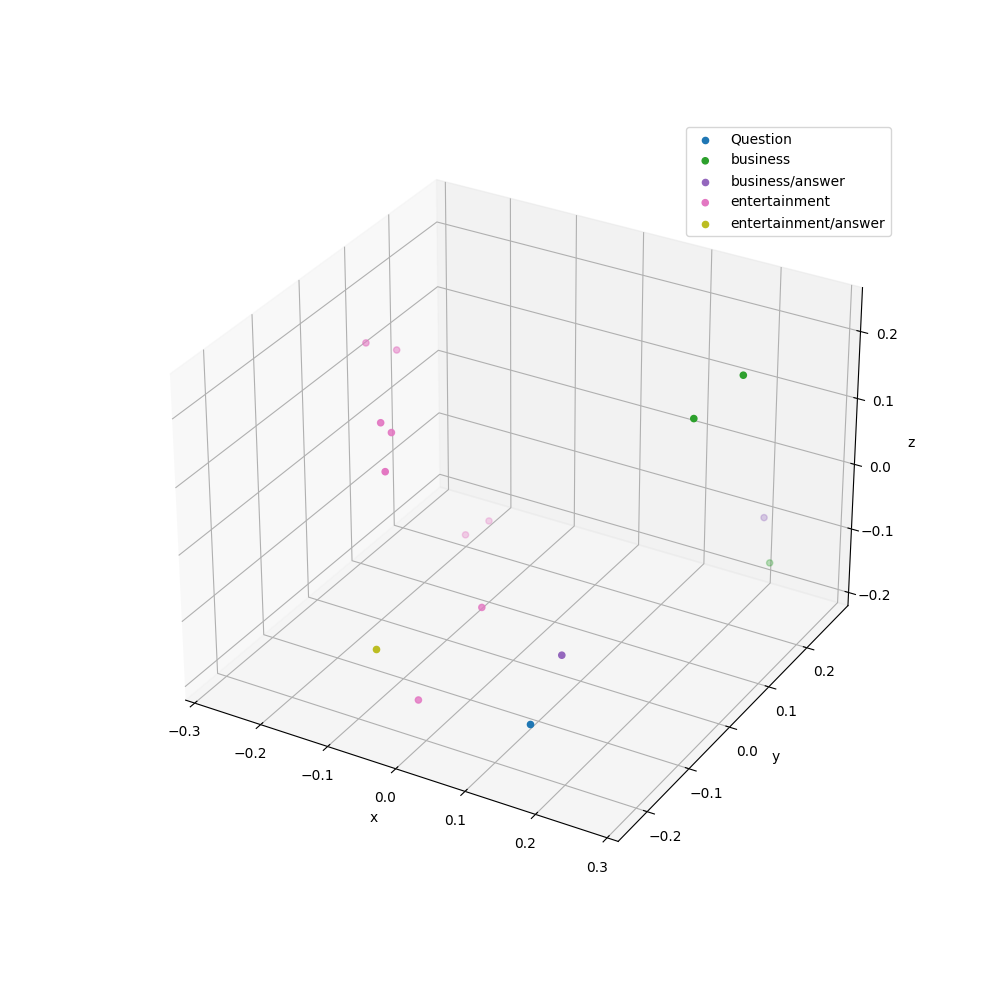

In [48]:
%matplotlib widget 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

categories = sorted(df['category'].unique())

# Plot each sample category individually
for i, cat in enumerate(categories):
    sub_matrix = np.array(df[df["category"] == cat]["vis_dims_pca"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    _ = ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

_ = ax.set_xlabel('x')
_ = ax.set_ylabel('y')
_ = ax.set_zlabel('z')
_ = ax.legend()